# Model Framework Design

Goal: Compare XGBoost and Random Forest (along with other strong classifiers) to select the best-performing model for predicting sales time.

Evaluation Metrics:

Classification Metrics:

F1-Score: Balances precision and recall across all classes.

ROC-AUC: Measures the ability to distinguish between classes.

Class-Specific Analysis:

Focus on Recall and Precision for minority classes (e.g., slow sales).

# Model Optimization

Feature Engineering:

Extract time-related features (e.g., sales duration, periodic patterns).

Apply log transformations for skewed numerical features (e.g., price).

Encode categorical variables using target encoding or one-hot encoding.

Generate interaction features to capture complex relationships (e.g., price × seller rating).

Class Balancing:

Use oversampling methods like SMOTE for underrepresented classes.

Experiment with undersampling majority classes.

Tune class weight parameters (e.g., scale_pos_weight in XGBoost).

Hyperparameter Tuning:

For XGBoost:

Learning Rate (eta): Optimize in the range of 0.01-0.1.

Tree Depth (max_depth): Adjust between 6-10 for balanced complexity.

Regularization (lambda, alpha): Fine-tune to avoid overfitting.

Validation Strategy:

Apply Stratified K-Fold Cross Validation to maintain consistent class distributions.

Evaluate model robustness using different train-test splits.

# Model Explainability

Feature Importance Analysis:

For XGBoost: Evaluate Gain (accuracy improvement), Weight (usage frequency), and Cover (sample impact).

For Random Forest: Assess Gini Importance or Permutation Importance.

Visualize feature importance with libraries like matplotlib or XGBoost’s plot_importance.

SHAP Analysis:

Use SHAP to provide consistent comparison of feature contributions across models.

Compare global feature impact between XGBoost and Random Forest.

Generate local explanations for specific predictions to evaluate interpretability.

Partial Dependence Plots (PDP):

Visualize how single features (e.g., price, feedback score) affect predictions globally.

Compare PDPs between XGBoost and Random Forest to detect consistent trends.

Interaction Effects:

Leverage SHAP Interaction values to explore feature pair interactions.

Highlight any differences in how XGBoost and Random Forest handle interactions.

Tree Visualization:

For Random Forest: Analyze decision paths from individual trees.

For XGBoost: Visualize key trees to understand split decisions.

# Part 1:Model Optimization

(1)Feature Engineering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# load the dataset
df = pd.read_csv('transformed_data_fl.csv')

In [4]:
df

,Feedback Score,Positive Feedback %,Shipping Cost,Time duration,Gallery URL_flag,Store URL_flag,Large Image URL_flag,Super Size Image URL_flag,Store Name_flag,Price_in_USD,Cost_to_Price_Ratio,Feedback_Quality,Is_Trusted_Seller,Price_Condition,Condition_Encoded,Category_Encoded,Shipping Type_Encoded,Listing Type_Encoded,Shipping_Listing_Type_Encoded
0,1520,100.0,NaN,7.000000,1,0,0,0,0,3.99,NaN,1520.000,0.000,3.990,2,134,0,1,3
1,1225,100.0,0.00,61.041667,1,0,1,1,0,6.88,0.0000,1225.000,0.000,6.880,2,134,4,2,20
2,4,70.0,0.00,29.749769,1,0,1,1,0,6.64,0.0000,2.800,0.000,5.976,0,134,4,2,20
3,3660470,98.4,0.00,61.041667,1,1,1,1,1,4.89,0.0000,3601902.480,0.000,4.401,0,134,4,2,20
4,5302,99.1,NaN,30.000000,1,0,1,1,0,18.00,NaN,5254.282,5254.282,12.600,4,134,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127773,8,100.0,3.99,1187.041667,1,0,1,1,0,5.60,0.7125,8.000,0.000,1.680,3,457,2,2,12
127774,67910,99.3,0.00,91.041667,1,1,1,1,1,11.71,0.0000,67434.630,0.000,3.513,3,457,4,2,20
127775,67910,99.3,0.00,91.041667,1,1,1,1,1,13.05,0.0000,67434.630,0.000,3.915,3,457,4,2,20
127776,67910,99.3,0.00,91.041667,1,1,1,1,1,13.11,0.0000,67434.630,0.000,3.933,3,457,4,2,20


In [5]:
df.isnull().sum()

Feedback Score                       0
Positive Feedback %                  0
Shipping Cost                    25977
Time duration                        0
Gallery URL_flag                     0
Store URL_flag                       0
Large Image URL_flag                 0
Super Size Image URL_flag            0
Store Name_flag                      0
Price_in_USD                         0
Cost_to_Price_Ratio              25977
Feedback_Quality                     0
Is_Trusted_Seller                    0
Price_Condition                      0
Condition_Encoded                    0
Category_Encoded                     0
Shipping Type_Encoded                0
Listing Type_Encoded                 0
Shipping_Listing_Type_Encoded        0
dtype: int64

-categorize the y_sales time

In [6]:

df['Time duration'].describe()

count    127778.000000
mean        379.747041
std         592.185923
min           1.000000
25%          31.041667
50%          92.041667
75%         457.041667
max        6698.041667
Name: Time duration, dtype: float64

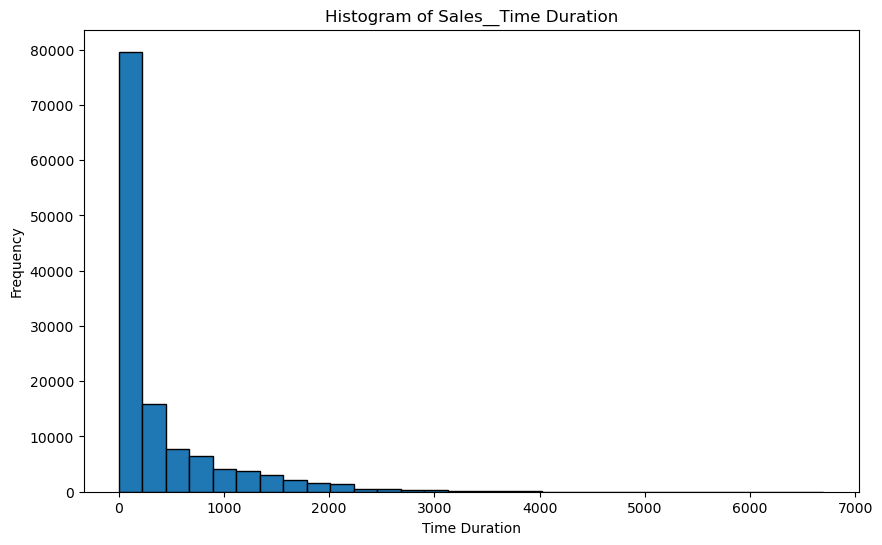

In [7]:
plt.figure(figsize=(10, 6))  
plt.hist(df['Time duration'], bins=30, edgecolor='black')  

plt.title('Histogram of Sales__Time Duration')
plt.xlabel('Time Duration')
plt.ylabel('Frequency')

plt.show()

In [8]:
# calculate the quantiles
time_duration=df['Time duration']
quantiles = time_duration.quantile([0, 0.25, 0.5, 0.75, 1]).values.round().astype(int)
print("quantiles:", quantiles)

quantiles: [   1   31   92  457 6698]


In [9]:
# Divide the time duration into 4 catergories.
df['category_timeDuration'] = pd.cut(df['Time duration'], 
                        bins=[0, 30, 90, 360, float('inf')], 
                        labels=['0-30 days', '30-90 days', '90-360 days', '>360 days'])

In [10]:
df = df.drop(['Shipping_Listing_Type_Encoded'],axis=1)

In [11]:
df

,Feedback Score,Positive Feedback %,Shipping Cost,Time duration,Gallery URL_flag,Store URL_flag,Large Image URL_flag,Super Size Image URL_flag,Store Name_flag,Price_in_USD,Cost_to_Price_Ratio,Feedback_Quality,Is_Trusted_Seller,Price_Condition,Condition_Encoded,Category_Encoded,Shipping Type_Encoded,Listing Type_Encoded,category_timeDuration
0,1520,100.0,NaN,7.000000,1,0,0,0,0,3.99,NaN,1520.000,0.000,3.990,2,134,0,1,0-30 days
1,1225,100.0,0.00,61.041667,1,0,1,1,0,6.88,0.0000,1225.000,0.000,6.880,2,134,4,2,30-90 days
2,4,70.0,0.00,29.749769,1,0,1,1,0,6.64,0.0000,2.800,0.000,5.976,0,134,4,2,0-30 days
3,3660470,98.4,0.00,61.041667,1,1,1,1,1,4.89,0.0000,3601902.480,0.000,4.401,0,134,4,2,30-90 days
4,5302,99.1,NaN,30.000000,1,0,1,1,0,18.00,NaN,5254.282,5254.282,12.600,4,134,0,2,0-30 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127773,8,100.0,3.99,1187.041667,1,0,1,1,0,5.60,0.7125,8.000,0.000,1.680,3,457,2,2,>360 days
127774,67910,99.3,0.00,91.041667,1,1,1,1,1,11.71,0.0000,67434.630,0.000,3.513,3,457,4,2,90-360 days
127775,67910,99.3,0.00,91.041667,1,1,1,1,1,13.05,0.0000,67434.630,0.000,3.915,3,457,4,2,90-360 days
127776,67910,99.3,0.00,91.041667,1,1,1,1,1,13.11,0.0000,67434.630,0.000,3.933,3,457,4,2,90-360 days


In [12]:
# encode the label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['y_label'] = label_encoder.fit_transform(df['category_timeDuration'])

In [13]:
df['y_label'].value_counts()

y_label
1    40265
3    39418
2    29700
0    18395
Name: count, dtype: int64

In [14]:
# retain the mappint relation of category_timeDuration & y_label
cateogory_timeduration_map = df.groupby('category_timeDuration')['y_label'].apply(lambda x:list(set(x))).to_dict()
print(cateogory_timeduration_map)

{'0-30 days': [0], '30-90 days': [1], '90-360 days': [2], '>360 days': [3]}


/var/folders/4c/dthy1t0x1_q220nr2z759xb80000gn/T/ipykernel_19893/1521826583.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cateogory_timeduration_map = df.groupby('category_timeDuration')['y_label'].apply(lambda x:list(set(x))).to_dict()


In [15]:
df = df.drop(['Time duration','category_timeDuration'],axis=1)

In [16]:
df

,Feedback Score,Positive Feedback %,Shipping Cost,Gallery URL_flag,Store URL_flag,Large Image URL_flag,Super Size Image URL_flag,Store Name_flag,Price_in_USD,Cost_to_Price_Ratio,Feedback_Quality,Is_Trusted_Seller,Price_Condition,Condition_Encoded,Category_Encoded,Shipping Type_Encoded,Listing Type_Encoded,y_label
0,1520,100.0,NaN,1,0,0,0,0,3.99,NaN,1520.000,0.000,3.990,2,134,0,1,0
1,1225,100.0,0.00,1,0,1,1,0,6.88,0.0000,1225.000,0.000,6.880,2,134,4,2,1
2,4,70.0,0.00,1,0,1,1,0,6.64,0.0000,2.800,0.000,5.976,0,134,4,2,0
3,3660470,98.4,0.00,1,1,1,1,1,4.89,0.0000,3601902.480,0.000,4.401,0,134,4,2,1
4,5302,99.1,NaN,1,0,1,1,0,18.00,NaN,5254.282,5254.282,12.600,4,134,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127773,8,100.0,3.99,1,0,1,1,0,5.60,0.7125,8.000,0.000,1.680,3,457,2,2,3
127774,67910,99.3,0.00,1,1,1,1,1,11.71,0.0000,67434.630,0.000,3.513,3,457,4,2,2
127775,67910,99.3,0.00,1,1,1,1,1,13.05,0.0000,67434.630,0.000,3.915,3,457,4,2,2
127776,67910,99.3,0.00,1,1,1,1,1,13.11,0.0000,67434.630,0.000,3.933,3,457,4,2,2


In [17]:
df_nofeature_interaction =df.drop(['Cost_to_Price_Ratio','Feedback_Quality','Is_Trusted_Seller','Price_Condition'],axis=1)

In [18]:
df.describe()

,Feedback Score,Positive Feedback %,Shipping Cost,Gallery URL_flag,Store URL_flag,Large Image URL_flag,Super Size Image URL_flag,Store Name_flag,Price_in_USD,Cost_to_Price_Ratio,Feedback_Quality,Is_Trusted_Seller,Price_Condition,Condition_Encoded,Category_Encoded,Shipping Type_Encoded,Listing Type_Encoded,y_label
count,1.277780e+05,127778.000000,101801.000000,127778.000000,127778.000000,127778.000000,127778.000000,127778.000000,127778.000000,101801.000000,1.277780e+05,1.277780e+05,127778.000000,127778.000000,127778.000000,127778.000000,127778.000000,127778.000000
mean,2.611689e+05,97.001042,1.814113,0.989130,0.829947,0.960259,0.960259,0.829947,27.701155,0.257979,2.574865e+05,1.410858e+05,12.955427,2.759309,527.207328,2.776847,1.959093,1.705450
std,8.593486e+05,13.838517,4.885600,0.103693,0.375681,0.195350,0.195350,0.375681,325.932256,8.654309,8.480676e+05,6.407299e+05,204.144288,1.056340,365.716769,1.589995,0.285446,1.054844
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007800,0.000000,0.000000e+00,0.000000e+00,0.003000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.020000e+02,98.500000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.500000,0.000000,2.973020e+02,0.000000e+00,3.384000,3.000000,267.000000,2.000000,2.000000,1.000000
50%,1.758000e+03,99.600000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.890000,0.000000,1.745694e+03,0.000000e+00,6.293000,3.000000,455.000000,4.000000,2.000000,2.000000
75%,1.090600e+04,100.000000,1.830000,1.000000,1.000000,1.000000,1.000000,1.000000,25.000000,0.198397,1.085048e+04,2.521000e+03,13.160000,3.000000,724.000000,4.000000,2.000000,3.000000
max,1.252920e+07,100.000000,375.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100000.000000,1899.000000,1.245402e+07,3.700667e+06,70000.000000,4.000000,1248.000000,7.000000,3.000000,3.000000


In [19]:
df_nofeature_interaction

,Feedback Score,Positive Feedback %,Shipping Cost,Gallery URL_flag,Store URL_flag,Large Image URL_flag,Super Size Image URL_flag,Store Name_flag,Price_in_USD,Condition_Encoded,Category_Encoded,Shipping Type_Encoded,Listing Type_Encoded,y_label
0,1520,100.0,NaN,1,0,0,0,0,3.99,2,134,0,1,0
1,1225,100.0,0.00,1,0,1,1,0,6.88,2,134,4,2,1
2,4,70.0,0.00,1,0,1,1,0,6.64,0,134,4,2,0
3,3660470,98.4,0.00,1,1,1,1,1,4.89,0,134,4,2,1
4,5302,99.1,NaN,1,0,1,1,0,18.00,4,134,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127773,8,100.0,3.99,1,0,1,1,0,5.60,3,457,2,2,3
127774,67910,99.3,0.00,1,1,1,1,1,11.71,3,457,4,2,2
127775,67910,99.3,0.00,1,1,1,1,1,13.05,3,457,4,2,2
127776,67910,99.3,0.00,1,1,1,1,1,13.11,3,457,4,2,2


# Initialize XGBoost and bulid Dmatrix for engeering_with Feature interaction

In [20]:
X = df.iloc[:,:-1]

In [21]:
y = df.iloc[:,-1]

In [22]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [23]:
# XGB_Model with feature interaction

In [24]:
# trains an XGBoost model, retrieves the feature importances, and displays them in descending order.
# Train an initial XGBoost model
import xgboost as xgb
model_XGB_with_fi = xgb.XGBClassifier(objective='multi:softmax', num_class=4)
model_XGB_with_fi.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [63]:
# Evaluate performance
score_with_fi = model_XGB_with_fi.score(X_test, y_test)
print("Model accuracy with feature interaction':", score_with_fi)


Model accuracy with feature interaction': 0.6131632493347942


In [64]:
# XGB_Model without feature interaction

In [47]:
X_no_fi = df_nofeature_interaction.iloc[:,:-1]

In [43]:
y_no_fi = df_nofeature_interaction.iloc[:,-1]

In [48]:
# split X and y into training and testing sets

X_no_fi_train, X_no_fi_test, y_no_fi_train, y_no_fi_test = train_test_split(X_no_fi, y_no_fi, test_size = 0.2, random_state = 0)

In [49]:
model_XGB_no_fi = xgb.XGBClassifier(objective='multi:softmax', num_class=4)
model_XGB_no_fi.fit(X_no_fi_train, y_no_fi_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [62]:
# Evaluate performance
score_no_fi = model_XGB_no_fi.score(X_no_fi_test, y_no_fi_test)
print("Model accuracy without feature interaction:", score_no_fi)

Model accuracy without feature interaction: 0.6069024886523713


In [65]:
# Get feature importance (with feature interaction)

In [33]:
feature_importances = model_XGB_with_fi.feature_importances_

# Combine features and their importance into a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': feature_importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

                      feature  importance
16       Listing Type_Encoded    0.464762
4              Store URL_flag    0.084411
15      Shipping Type_Encoded    0.079858
10           Feedback_Quality    0.062470
3            Gallery URL_flag    0.056515
14           Category_Encoded    0.035479
11          Is_Trusted_Seller    0.032581
0              Feedback Score    0.030784
2               Shipping Cost    0.029191
1         Positive Feedback %    0.028005
13          Condition_Encoded    0.025500
8                Price_in_USD    0.021217
9         Cost_to_Price_Ratio    0.019299
5        Large Image URL_flag    0.015596
12            Price_Condition    0.014330
7             Store Name_flag    0.000000
6   Super Size Image URL_flag    0.000000


In [34]:
# Drop the dominant feature
X_train_drop = X_train.drop(columns=['Listing Type_Encoded'])
X_test_drop = X_test.drop(columns=['Listing Type_Encoded'])

In [53]:
# bulid model with the data no list of type
model_XGB_with_fi_drop_listtype = xgb.XGBClassifier(objective='multi:softmax', num_class=4)
model_XGB_with_fi_drop_listtype.fit(X_train_drop, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [54]:
# Evaluate performance
score_no_dominant = model_XGB_with_fi_drop_listtype.score(X_test_drop, y_test)
print("Model accuracy without 'Listing Type_Encoded':", score_no_dominant)

Model accuracy without 'Listing Type_Encoded': 0.6037329785568947


In [56]:
feature_importances_drop = model_XGB_with_fi_drop_listtype.feature_importances_

# Combine features and their importance into a DataFrame for easy viewing
feature_importances_drop_df = pd.DataFrame({
    'feature': X_train_drop.columns,
    'importance': feature_importances_drop
})

# Sort by importance in descending order
feature_importances_drop_df = feature_importances_drop_df.sort_values(by='importance', ascending=False)
print(feature_importances_drop_df)

                      feature  importance
15      Shipping Type_Encoded    0.162222
4              Store URL_flag    0.154609
10           Feedback_Quality    0.109146
3            Gallery URL_flag    0.108008
14           Category_Encoded    0.066626
11          Is_Trusted_Seller    0.060522
2               Shipping Cost    0.053664
0              Feedback Score    0.052899
1         Positive Feedback %    0.052811
8                Price_in_USD    0.044992
13          Condition_Encoded    0.041137
5        Large Image URL_flag    0.031487
12            Price_Condition    0.031116
9         Cost_to_Price_Ratio    0.030761
6   Super Size Image URL_flag    0.000000
7             Store Name_flag    0.000000


# To answer a question: why Listing Type_Encoded very important but no difference in accuracy after dropping it

In [57]:
# step1: statistical traits of the list_type

In [58]:
correlation = df[['Listing Type_Encoded', 'y_label']].corr()
print(correlation)

                      Listing Type_Encoded   y_label
Listing Type_Encoded              1.000000  0.248153
y_label                           0.248153  1.000000


Listing Type_Encoded
2    124614
0      2487
1       465
3       212
Name: count, dtype: int64


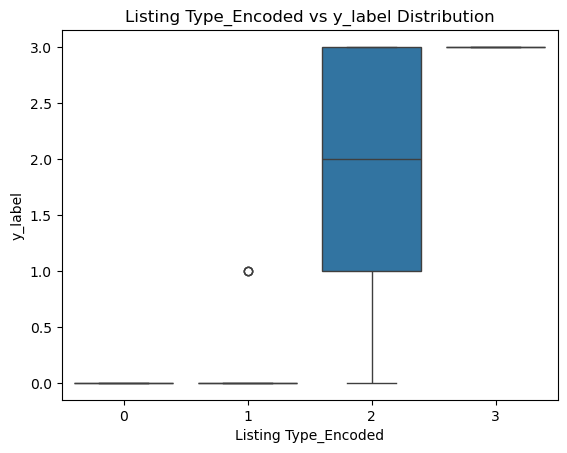

In [59]:
print(df['Listing Type_Encoded'].value_counts())
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Listing Type_Encoded', y='y_label', data=df)
plt.title('Listing Type_Encoded vs y_label Distribution')
plt.show()

In [ ]:
step 2:Analyze the feature’s standalone effect

In [60]:
# Apply simple model by standalone feature
from sklearn.linear_model import LogisticRegression
X_single = X_train[['Listing Type_Encoded']]
model_single = LogisticRegression()
model_single.fit(X_single, y_train)
score_single = model_single.score(X_test[['Listing Type_Encoded']], y_test)
print("Accurary of standalone feature：", score_single)

Accurary of standalone feature： 0.3412897167005791


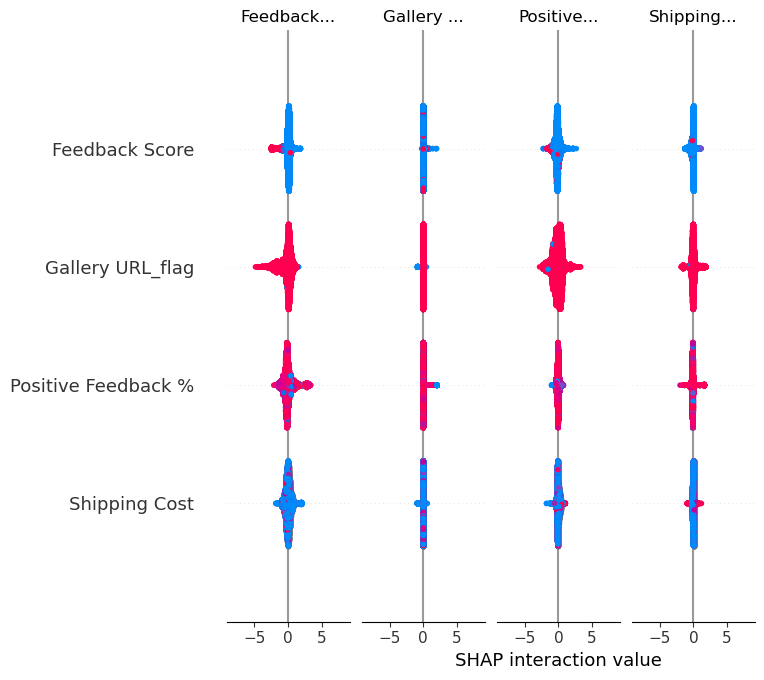

In [61]:
# Evaluate feature interaction contributions
import shap
explainer = shap.TreeExplainer(model_XGB_with_fi)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)  # visulization of features and interaction

In [ ]:
# the result could be: the categories of list_type is imbalanced, so 

# Compare the XGboost and RandomForest by default parameters

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


# Initialize the Random Forest model with default parameters
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# accuracy in training of randomforest after tuning
y_train_pred = rf_model.predict(X_train)  # Training predictions
# Evaluate the model's performance on training set
print("Training Set Performance:")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.63      0.69      3633
           1       0.71      0.69      0.70      8106
           2       0.54      0.53      0.54      5940
           3       0.66      0.75      0.70      7877

    accuracy                           0.66     25556
   macro avg       0.67      0.65      0.66     25556
weighted avg       0.66      0.66      0.66     25556

Confusion Matrix:
[[2281  691  330  331]
 [ 460 5621 1003 1022]
 [ 138 1043 3125 1634]
 [  83  615 1281 5898]]
Training Set Performance:
Training Accuracy: 0.9891
Training Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14762
           1       0.99      0.99      0.99     32159
           2       0.99      0.98      0.98     23760
           3       0.99      0.99      0.99     31541

    accuracy                           0.99    102222
   macro avg       0.

In [135]:
# Hyperparameter Tuning with Grid Search(random forest)

In [140]:
from sklearn.model_selection import GridSearchCV

#  Parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
                     }

#  Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Evalute by best parameters
best_rf = grid_search.best_estimator_
train_accuracy = accuracy_score(y_train, best_rf.predict(X_train))
test_accuracy = accuracy_score(y_test, best_rf.predict(X_test))

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training Accuracy: 0.7171
Test Accuracy: 0.6295
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  24.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  13.9s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=  15.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=  14.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=  15.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  28.1s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  19.8s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=50; t

In [27]:
# RandomForest_tuning1
# Define the Random Forest model with the best parameters
rf_model_tun1 = RandomForestClassifier(
    max_depth=15,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)

# Train the model on the training set
rf_model_tun1.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model_tun1.predict(X_test)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# accuracy in training of randomforest after tuning
y_train_pred = rf_model_tun1.predict(X_train)  # Training predictions
# Evaluate the model's performance on training set
print("Training Set Performance:")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.48      0.61      3633
           1       0.69      0.65      0.67      8106
           2       0.53      0.44      0.48      5940
           3       0.59      0.82      0.69      7877

    accuracy                           0.63     25556
   macro avg       0.67      0.60      0.61     25556
weighted avg       0.65      0.63      0.62     25556

Confusion Matrix:
[[1726 1005  329  573]
 [ 207 5254 1037 1608]
 [  51  903 2612 2374]
 [  22  403  957 6495]]
Training Set Performance:
Training Accuracy: 0.7171
Training Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.53      0.67     14762
           1       0.76      0.72      0.74     32159
           2       0.69      0.59      0.63     23760
           3       0.66      0.89      0.76     31541

    accuracy                           0.72    102222
   macro avg       0.

In [28]:
# RandomForest_tuning2
# Define the Random Forest model with the best parameters
rf_model_tun2 = RandomForestClassifier(
    max_depth=15,
    min_samples_leaf=20,
    min_samples_split=30,
    n_estimators=200,
    random_state=42
)

# Train the model on the training set
rf_model_tun2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model_tun2.predict(X_test)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# accuracy in training of randomforest after tuning
y_train_pred = rf_model_tun2.predict(X_train)  # Training predictions
# Evaluate the model's performance on training set
print("Training Set Performance:")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.41      0.56      3633
           1       0.66      0.64      0.65      8106
           2       0.50      0.38      0.44      5940
           3       0.57      0.82      0.67      7877

    accuracy                           0.60     25556
   macro avg       0.65      0.56      0.58     25556
weighted avg       0.62      0.60      0.59     25556

Confusion Matrix:
[[1500 1159  340  634]
 [ 199 5149 1015 1743]
 [  39 1008 2286 2607]
 [  21  466  905 6485]]
Training Set Performance:
Training Accuracy: 0.6365
Training Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.43      0.58     14762
           1       0.68      0.65      0.67     32159
           2       0.57      0.44      0.50     23760
           3       0.59      0.86      0.70     31541

    accuracy                           0.64    102222
   macro avg       0.

In [29]:
# RandomForest_tuning3
# Define the Random Forest model with the best parameters
rf_model_tun3 = RandomForestClassifier(
    max_depth=15,
    min_samples_leaf=30,
    min_samples_split=40,
    n_estimators=250,
    random_state=42
)

# Train the model on the training set
rf_model_tun3.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model_tun3.predict(X_test)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# accuracy in training of randomforest after tuning
y_train_pred = rf_model_tun3.predict(X_train)  # Training predictions
# Evaluate the model's performance on training set
print("Training Set Performance:")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.40      0.54      3633
           1       0.66      0.63      0.64      8106
           2       0.49      0.37      0.43      5940
           3       0.56      0.82      0.66      7877

    accuracy                           0.60     25556
   macro avg       0.64      0.56      0.57     25556
weighted avg       0.61      0.60      0.58     25556

Confusion Matrix:
[[1444 1192  345  652]
 [ 212 5080 1026 1788]
 [  36 1001 2226 2677]
 [  24  480  902 6471]]
Training Set Performance:
Training Accuracy: 0.6213
Training Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.41      0.56     14762
           1       0.67      0.64      0.65     32159
           2       0.55      0.42      0.48     23760
           3       0.58      0.85      0.69     31541

    accuracy                           0.62    102222
   macro avg       0.

In [30]:
# RandomForest_tuning4
# Define the Random Forest model with the best parameters
rf_model_tun4 = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=40,
    min_samples_split=50,
    n_estimators=300,
    random_state=42
)

# Train the model on the training set
rf_model_tun4.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model_tun4.predict(X_test)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# accuracy in training of randomforest after tuning
y_train_pred = rf_model_tun4.predict(X_train)  # Training predictions
# Evaluate the model's performance on training set
print("Training Set Performance:")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.33      0.48      3633
           1       0.63      0.59      0.61      8106
           2       0.46      0.29      0.35      5940
           3       0.51      0.83      0.64      7877

    accuracy                           0.56     25556
   macro avg       0.61      0.51      0.52     25556
weighted avg       0.58      0.56      0.54     25556

Confusion Matrix:
[[1201 1317  324  791]
 [ 167 4777  938 2224]
 [  17 1002 1707 3214]
 [  16  515  782 6564]]
Training Set Performance:
Training Accuracy: 0.5635
Training Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.34      0.49     14762
           1       0.62      0.58      0.60     32159
           2       0.48      0.31      0.37     23760
           3       0.52      0.84      0.64     31541

    accuracy                           0.56    102222
   macro avg       0.

# Initialize the XGBoost model for multi-class classification

In [68]:

xgb_model = XGBClassifier(
    objective='multi:softmax',  # Use softmax for multi-class classification
    num_class=4,               # Specify the number of classes (4 in this case)
    use_label_encoder=False,   # Disable label encoder (for newer XGBoost versions)
    eval_metric='mlogloss',    # Multi-class log-loss evaluation metric
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

/Users/yangbo/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.50      0.60      3633
           1       0.66      0.65      0.65      8106
           2       0.49      0.43      0.46      5940
           3       0.61      0.77      0.68      7877

    accuracy                           0.61     25556
   macro avg       0.63      0.59      0.60     25556
weighted avg       0.62      0.61      0.61     25556

Confusion Matrix:
[[1799  987  376  471]
 [ 375 5241 1150 1340]
 [ 107 1125 2572 2136]
 [  68  599 1152 6058]]


In [69]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score

# Define the number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize models
rf_model_test = RandomForestClassifier(random_state=42)
xgb_model_test = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Custom scorer for multi-class F1-score (weighted)
scorer = make_scorer(f1_score, average='weighted')

# Perform K-Fold Cross-Validation for Random Forest
rf_scores = cross_val_score(rf_model_test, X, y, cv=kf, scoring=scorer)
print(f"Random Forest - Average F1-Score: {rf_scores.mean():.4f} (Std: {rf_scores.std():.4f})")

# Perform K-Fold Cross-Validation for XGBoost
xgb_scores = cross_val_score(xgb_model_test, X, y, cv=kf, scoring=scorer)
print(f"XGBoost - Average F1-Score: {xgb_scores.mean():.4f} (Std: {xgb_scores.std():.4f})")

Random Forest - Average F1-Score: 0.6615 (Std: 0.0019)


/Users/yangbo/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yangbo/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:48:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yangbo/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:48:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yangbo/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

XGBoost - Average F1-Score: 0.6048 (Std: 0.0020)


In [70]:
# pararmeters tuning
from sklearn.model_selection import RandomizedSearchCV

In [72]:
from xgboost import XGBClassifier


# Configure the model:
# Declare parameters to reduce overfitting
# Cautions: the following parameters are just setted by intuition. we will tuin them next.
params = {
    'objective': 'multi:softmax',   # Specifies a multi-class classification objective
    'num_class': 4,                 # Specifies the number of classes in the target variable
    'max_depth': 8,                 # Limits the depth of each tree to control complexity
    'alpha': 10,                    # Adds L1 regularization to reduce overfitting
    'learning_rate': 0.3,           # Sets the learning rate to control the impact of each tree
    'n_estimators': 150             # Specifies the number of trees (boosting rounds)
}

# Instantiate the classifier with the specified parameters
xgb_tun1 = XGBClassifier(**params)

# Fit the classifier to the training data
xgb_tun1.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None, num_class=4, ...)

In [73]:
# make predictions on test data
y_pred = xgb_tun1.predict(X_test)

In [75]:
# check accuracy score
# this is the accuracy result withou any tuning
from sklearn.metrics import accuracy_score
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.6315


In [77]:
# parameter tuning using GridSearchCV

In [83]:
# Convert the datasets into DMatrix format
dtrain = DMatrix(data=X_train, label=y_train)
dtest = DMatrix(data=X_test, label=y_test)

In [86]:
# Revised parameters for tuning
params_tun2 = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,               # Number of classes
    'colsample_bytree': 0.3,      # Column sampling for each tree
    'learning_rate': 0.05,        # Lower learning rate for better generalization
    'max_depth': 15,              # Deeper trees
    'alpha': 5,                   # L1 regularization term
    'lambda': 1,                  # L2 regularization term
    'seed': 42                    # For reproducibility
}

In [87]:
# Define evaluation set (optional, for tracking progress)
evals = [(dtrain, 'train'), (dtest, 'test')]

In [88]:
# Train the model
best_num_boost_round = 1500  # Use the best number of boosting rounds obtained from previous tuning
XGB_model_tun2 = train(
    params=params_tun2,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round,
    evals=evals,                    # Track training progress
    early_stopping_rounds=10        # Stop if no improvement after 10 rounds
)

[0]	train-mlogloss:1.36416	test-mlogloss:1.36501
[1]	train-mlogloss:1.34277	test-mlogloss:1.34454
[2]	train-mlogloss:1.32979	test-mlogloss:1.33230
[3]	train-mlogloss:1.31047	test-mlogloss:1.31412
[4]	train-mlogloss:1.29736	test-mlogloss:1.30141
[5]	train-mlogloss:1.27936	test-mlogloss:1.28466
[6]	train-mlogloss:1.26573	test-mlogloss:1.27174
[7]	train-mlogloss:1.25127	test-mlogloss:1.25785
[8]	train-mlogloss:1.23759	test-mlogloss:1.24488
[9]	train-mlogloss:1.22534	test-mlogloss:1.23347
[10]	train-mlogloss:1.21135	test-mlogloss:1.22026
[11]	train-mlogloss:1.20217	test-mlogloss:1.21178
[12]	train-mlogloss:1.18951	test-mlogloss:1.19989
[13]	train-mlogloss:1.17830	test-mlogloss:1.18945
[14]	train-mlogloss:1.16959	test-mlogloss:1.18121
[15]	train-mlogloss:1.15888	test-mlogloss:1.17131
[16]	train-mlogloss:1.15032	test-mlogloss:1.16324
[17]	train-mlogloss:1.14120	test-mlogloss:1.15487
[18]	train-mlogloss:1.13177	test-mlogloss:1.14629
[19]	train-mlogloss:1.12283	test-mlogloss:1.13805
[20]	train

[163]	train-mlogloss:0.78166	test-mlogloss:0.86656
[164]	train-mlogloss:0.78081	test-mlogloss:0.86604
[165]	train-mlogloss:0.78001	test-mlogloss:0.86559
[166]	train-mlogloss:0.77881	test-mlogloss:0.86491
[167]	train-mlogloss:0.77790	test-mlogloss:0.86448
[168]	train-mlogloss:0.77697	test-mlogloss:0.86409
[169]	train-mlogloss:0.77625	test-mlogloss:0.86383
[170]	train-mlogloss:0.77550	test-mlogloss:0.86350
[171]	train-mlogloss:0.77482	test-mlogloss:0.86318
[172]	train-mlogloss:0.77397	test-mlogloss:0.86277
[173]	train-mlogloss:0.77361	test-mlogloss:0.86257
[174]	train-mlogloss:0.77283	test-mlogloss:0.86216
[175]	train-mlogloss:0.77208	test-mlogloss:0.86169
[176]	train-mlogloss:0.77124	test-mlogloss:0.86130
[177]	train-mlogloss:0.77071	test-mlogloss:0.86101
[178]	train-mlogloss:0.76986	test-mlogloss:0.86062
[179]	train-mlogloss:0.76927	test-mlogloss:0.86029
[180]	train-mlogloss:0.76856	test-mlogloss:0.86000
[181]	train-mlogloss:0.76787	test-mlogloss:0.85975
[182]	train-mlogloss:0.76742	te

[324]	train-mlogloss:0.69708	test-mlogloss:0.83189
[325]	train-mlogloss:0.69673	test-mlogloss:0.83175
[326]	train-mlogloss:0.69645	test-mlogloss:0.83165
[327]	train-mlogloss:0.69611	test-mlogloss:0.83148
[328]	train-mlogloss:0.69582	test-mlogloss:0.83139
[329]	train-mlogloss:0.69552	test-mlogloss:0.83128
[330]	train-mlogloss:0.69516	test-mlogloss:0.83115
[331]	train-mlogloss:0.69482	test-mlogloss:0.83106
[332]	train-mlogloss:0.69426	test-mlogloss:0.83087
[333]	train-mlogloss:0.69382	test-mlogloss:0.83074
[334]	train-mlogloss:0.69360	test-mlogloss:0.83068
[335]	train-mlogloss:0.69327	test-mlogloss:0.83058
[336]	train-mlogloss:0.69282	test-mlogloss:0.83041
[337]	train-mlogloss:0.69255	test-mlogloss:0.83037
[338]	train-mlogloss:0.69213	test-mlogloss:0.83026
[339]	train-mlogloss:0.69181	test-mlogloss:0.83015
[340]	train-mlogloss:0.69130	test-mlogloss:0.82997
[341]	train-mlogloss:0.69099	test-mlogloss:0.82990
[342]	train-mlogloss:0.69064	test-mlogloss:0.82977
[343]	train-mlogloss:0.69044	te

[485]	train-mlogloss:0.65134	test-mlogloss:0.81953
[486]	train-mlogloss:0.65121	test-mlogloss:0.81951
[487]	train-mlogloss:0.65089	test-mlogloss:0.81945
[488]	train-mlogloss:0.65075	test-mlogloss:0.81942
[489]	train-mlogloss:0.65051	test-mlogloss:0.81938
[490]	train-mlogloss:0.65026	test-mlogloss:0.81929
[491]	train-mlogloss:0.64985	test-mlogloss:0.81916
[492]	train-mlogloss:0.64958	test-mlogloss:0.81909
[493]	train-mlogloss:0.64931	test-mlogloss:0.81902
[494]	train-mlogloss:0.64916	test-mlogloss:0.81898
[495]	train-mlogloss:0.64904	test-mlogloss:0.81894
[496]	train-mlogloss:0.64889	test-mlogloss:0.81891
[497]	train-mlogloss:0.64865	test-mlogloss:0.81885
[498]	train-mlogloss:0.64837	test-mlogloss:0.81877
[499]	train-mlogloss:0.64803	test-mlogloss:0.81872
[500]	train-mlogloss:0.64765	test-mlogloss:0.81863
[501]	train-mlogloss:0.64741	test-mlogloss:0.81857
[502]	train-mlogloss:0.64718	test-mlogloss:0.81854
[503]	train-mlogloss:0.64686	test-mlogloss:0.81846
[504]	train-mlogloss:0.64662	te

[646]	train-mlogloss:0.61615	test-mlogloss:0.81337
[647]	train-mlogloss:0.61605	test-mlogloss:0.81335
[648]	train-mlogloss:0.61572	test-mlogloss:0.81327
[649]	train-mlogloss:0.61547	test-mlogloss:0.81319
[650]	train-mlogloss:0.61528	test-mlogloss:0.81315
[651]	train-mlogloss:0.61506	test-mlogloss:0.81309
[652]	train-mlogloss:0.61490	test-mlogloss:0.81306
[653]	train-mlogloss:0.61471	test-mlogloss:0.81303
[654]	train-mlogloss:0.61449	test-mlogloss:0.81303
[655]	train-mlogloss:0.61423	test-mlogloss:0.81300
[656]	train-mlogloss:0.61404	test-mlogloss:0.81299
[657]	train-mlogloss:0.61378	test-mlogloss:0.81293
[658]	train-mlogloss:0.61354	test-mlogloss:0.81291
[659]	train-mlogloss:0.61339	test-mlogloss:0.81291
[660]	train-mlogloss:0.61328	test-mlogloss:0.81288
[661]	train-mlogloss:0.61314	test-mlogloss:0.81281
[662]	train-mlogloss:0.61301	test-mlogloss:0.81279
[663]	train-mlogloss:0.61279	test-mlogloss:0.81276
[664]	train-mlogloss:0.61271	test-mlogloss:0.81274
[665]	train-mlogloss:0.61257	te

[807]	train-mlogloss:0.58899	test-mlogloss:0.81064
[808]	train-mlogloss:0.58886	test-mlogloss:0.81064
[809]	train-mlogloss:0.58876	test-mlogloss:0.81064
[810]	train-mlogloss:0.58857	test-mlogloss:0.81063
[811]	train-mlogloss:0.58833	test-mlogloss:0.81064
[812]	train-mlogloss:0.58824	test-mlogloss:0.81064
[813]	train-mlogloss:0.58808	test-mlogloss:0.81060
[814]	train-mlogloss:0.58800	test-mlogloss:0.81059
[815]	train-mlogloss:0.58794	test-mlogloss:0.81058
[816]	train-mlogloss:0.58773	test-mlogloss:0.81055
[817]	train-mlogloss:0.58761	test-mlogloss:0.81052
[818]	train-mlogloss:0.58753	test-mlogloss:0.81052
[819]	train-mlogloss:0.58731	test-mlogloss:0.81049
[820]	train-mlogloss:0.58725	test-mlogloss:0.81049
[821]	train-mlogloss:0.58703	test-mlogloss:0.81047
[822]	train-mlogloss:0.58691	test-mlogloss:0.81044
[823]	train-mlogloss:0.58675	test-mlogloss:0.81044
[824]	train-mlogloss:0.58655	test-mlogloss:0.81043
[825]	train-mlogloss:0.58642	test-mlogloss:0.81044
[826]	train-mlogloss:0.58627	te

In [89]:
# Make predictions on the test set
y_pred = XGB_model_tun2.predict(dtest)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6485
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.57      0.66      3633
           1       0.69      0.68      0.69      8106
           2       0.53      0.50      0.51      5940
           3       0.65      0.76      0.70      7877

    accuracy                           0.65     25556
   macro avg       0.66      0.63      0.64     25556
weighted avg       0.65      0.65      0.65     25556



Key Observations

	1.	Steady Reduction in Loss:
	•	Training loss consistently decreases throughout the iterations, indicating the model is learning from the data.
	•	Testing loss (test-mlogloss) also decreases initially but plateaus after a certain point (around iteration ~800).
	2.	Plateauing Test Loss:
	•	Beyond a certain number of boosting rounds, the testing loss stops improving, despite continued reductions in training loss.
	•	This behavior indicates the model might be overfitting to the training data if training continues unnecessarily.

Potential Problems

	1.	Overfitting:
	•	As training continues, the model could start overfitting to the training set, which is reflected in the stagnation of test loss (test-mlogloss).
	•	Training loss continues to drop, but this is no longer helping generalize the model.
	2.	Suboptimal Number of Boosting Rounds:
	•	The number of boosting rounds appears to be too high. Early stopping could prevent the unnecessary training that leads to overfitting.
	3.	Feature Importance or Quality:
	•	The model might rely too heavily on noisy or uninformative features that are not beneficial for test data.
	4.	Hyperparameter Choices:
	•	Parameters such as learning_rate, max_depth, or min_child_weight might not be optimal for your dataset, causing slow improvement or suboptimal results.

In [90]:
# Revised parameters for tuning
params_tun3 = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,               # Number of classes
    'colsample_bytree': 0.7,      # Increase column sampling to improve generalization
    'subsample': 0.8,             # Sample rows for each boosting round
    'learning_rate': 0.03,        # Lower learning rate for better generalization
    'max_depth': 10,              # Balanced tree depth
    'min_child_weight': 5,        # Control complexity of the model
    'gamma': 1,                   # Minimum loss reduction to split a node
    'alpha': 5,                   # L1 regularization term
    'lambda': 2,                  # Increased L2 regularization
    'seed': 42                    # For reproducibility
}

In [92]:
# Define evaluation set for tracking progress
evals = [(dtrain, 'train'), (dtest, 'validation')]

In [94]:
# Train the model with early stopping
XGB_model_tun3 = train(
    params=params_tun3,
    dtrain=dtrain,
    num_boost_round=900,         # Start with a lower number of boosting rounds
    evals=evals,                  # Track training and validation progress
    early_stopping_rounds=20      # Stop if no improvement after 20 rounds
)

[0]	train-mlogloss:1.37240	validation-mlogloss:1.37275
[1]	train-mlogloss:1.35943	validation-mlogloss:1.36008
[2]	train-mlogloss:1.34731	validation-mlogloss:1.34832
[3]	train-mlogloss:1.33504	validation-mlogloss:1.33649
[4]	train-mlogloss:1.32288	validation-mlogloss:1.32464
[5]	train-mlogloss:1.31158	validation-mlogloss:1.31369
[6]	train-mlogloss:1.30114	validation-mlogloss:1.30358
[7]	train-mlogloss:1.29002	validation-mlogloss:1.29285
[8]	train-mlogloss:1.27975	validation-mlogloss:1.28293
[9]	train-mlogloss:1.27029	validation-mlogloss:1.27376
[10]	train-mlogloss:1.26113	validation-mlogloss:1.26492
[11]	train-mlogloss:1.25202	validation-mlogloss:1.25625
[12]	train-mlogloss:1.24322	validation-mlogloss:1.24776
[13]	train-mlogloss:1.23545	validation-mlogloss:1.24012
[14]	train-mlogloss:1.22730	validation-mlogloss:1.23226
[15]	train-mlogloss:1.21868	validation-mlogloss:1.22401
[16]	train-mlogloss:1.21072	validation-mlogloss:1.21637
[17]	train-mlogloss:1.20353	validation-mlogloss:1.20947
[1

[146]	train-mlogloss:0.90809	validation-mlogloss:0.93734
[147]	train-mlogloss:0.90751	validation-mlogloss:0.93688
[148]	train-mlogloss:0.90687	validation-mlogloss:0.93635
[149]	train-mlogloss:0.90631	validation-mlogloss:0.93592
[150]	train-mlogloss:0.90576	validation-mlogloss:0.93548
[151]	train-mlogloss:0.90517	validation-mlogloss:0.93503
[152]	train-mlogloss:0.90454	validation-mlogloss:0.93454
[153]	train-mlogloss:0.90400	validation-mlogloss:0.93411
[154]	train-mlogloss:0.90341	validation-mlogloss:0.93364
[155]	train-mlogloss:0.90285	validation-mlogloss:0.93321
[156]	train-mlogloss:0.90230	validation-mlogloss:0.93276
[157]	train-mlogloss:0.90185	validation-mlogloss:0.93235
[158]	train-mlogloss:0.90119	validation-mlogloss:0.93182
[159]	train-mlogloss:0.90067	validation-mlogloss:0.93139
[160]	train-mlogloss:0.90011	validation-mlogloss:0.93093
[161]	train-mlogloss:0.89968	validation-mlogloss:0.93061
[162]	train-mlogloss:0.89909	validation-mlogloss:0.93013
[163]	train-mlogloss:0.89853	va

[290]	train-mlogloss:0.85625	validation-mlogloss:0.89946
[291]	train-mlogloss:0.85595	validation-mlogloss:0.89927
[292]	train-mlogloss:0.85573	validation-mlogloss:0.89911
[293]	train-mlogloss:0.85569	validation-mlogloss:0.89907
[294]	train-mlogloss:0.85548	validation-mlogloss:0.89895
[295]	train-mlogloss:0.85533	validation-mlogloss:0.89883
[296]	train-mlogloss:0.85518	validation-mlogloss:0.89873
[297]	train-mlogloss:0.85495	validation-mlogloss:0.89858
[298]	train-mlogloss:0.85482	validation-mlogloss:0.89850
[299]	train-mlogloss:0.85472	validation-mlogloss:0.89844
[300]	train-mlogloss:0.85467	validation-mlogloss:0.89841
[301]	train-mlogloss:0.85450	validation-mlogloss:0.89831
[302]	train-mlogloss:0.85435	validation-mlogloss:0.89823
[303]	train-mlogloss:0.85417	validation-mlogloss:0.89810
[304]	train-mlogloss:0.85401	validation-mlogloss:0.89800
[305]	train-mlogloss:0.85384	validation-mlogloss:0.89788
[306]	train-mlogloss:0.85355	validation-mlogloss:0.89769
[307]	train-mlogloss:0.85336	va

[434]	train-mlogloss:0.84016	validation-mlogloss:0.88945
[435]	train-mlogloss:0.84016	validation-mlogloss:0.88944
[436]	train-mlogloss:0.84007	validation-mlogloss:0.88938
[437]	train-mlogloss:0.84007	validation-mlogloss:0.88938
[438]	train-mlogloss:0.83998	validation-mlogloss:0.88931
[439]	train-mlogloss:0.83990	validation-mlogloss:0.88926
[440]	train-mlogloss:0.83988	validation-mlogloss:0.88925
[441]	train-mlogloss:0.83983	validation-mlogloss:0.88923
[442]	train-mlogloss:0.83981	validation-mlogloss:0.88922
[443]	train-mlogloss:0.83960	validation-mlogloss:0.88910
[444]	train-mlogloss:0.83951	validation-mlogloss:0.88904
[445]	train-mlogloss:0.83937	validation-mlogloss:0.88896
[446]	train-mlogloss:0.83935	validation-mlogloss:0.88894
[447]	train-mlogloss:0.83933	validation-mlogloss:0.88893
[448]	train-mlogloss:0.83933	validation-mlogloss:0.88893
[449]	train-mlogloss:0.83928	validation-mlogloss:0.88891
[450]	train-mlogloss:0.83919	validation-mlogloss:0.88884
[451]	train-mlogloss:0.83909	va

[578]	train-mlogloss:0.83356	validation-mlogloss:0.88548
[579]	train-mlogloss:0.83355	validation-mlogloss:0.88547
[580]	train-mlogloss:0.83354	validation-mlogloss:0.88547
[581]	train-mlogloss:0.83354	validation-mlogloss:0.88547
[582]	train-mlogloss:0.83348	validation-mlogloss:0.88544
[583]	train-mlogloss:0.83348	validation-mlogloss:0.88544
[584]	train-mlogloss:0.83347	validation-mlogloss:0.88543
[585]	train-mlogloss:0.83342	validation-mlogloss:0.88540
[586]	train-mlogloss:0.83342	validation-mlogloss:0.88540
[587]	train-mlogloss:0.83342	validation-mlogloss:0.88540
[588]	train-mlogloss:0.83342	validation-mlogloss:0.88540
[589]	train-mlogloss:0.83341	validation-mlogloss:0.88540
[590]	train-mlogloss:0.83341	validation-mlogloss:0.88540
[591]	train-mlogloss:0.83335	validation-mlogloss:0.88538
[592]	train-mlogloss:0.83335	validation-mlogloss:0.88538
[593]	train-mlogloss:0.83334	validation-mlogloss:0.88537
[594]	train-mlogloss:0.83326	validation-mlogloss:0.88532
[595]	train-mlogloss:0.83326	va

[722]	train-mlogloss:0.83009	validation-mlogloss:0.88355
[723]	train-mlogloss:0.83009	validation-mlogloss:0.88355
[724]	train-mlogloss:0.83001	validation-mlogloss:0.88349
[725]	train-mlogloss:0.83001	validation-mlogloss:0.88349
[726]	train-mlogloss:0.82992	validation-mlogloss:0.88344
[727]	train-mlogloss:0.82989	validation-mlogloss:0.88342
[728]	train-mlogloss:0.82984	validation-mlogloss:0.88339
[729]	train-mlogloss:0.82984	validation-mlogloss:0.88339
[730]	train-mlogloss:0.82982	validation-mlogloss:0.88337
[731]	train-mlogloss:0.82982	validation-mlogloss:0.88337
[732]	train-mlogloss:0.82982	validation-mlogloss:0.88337
[733]	train-mlogloss:0.82981	validation-mlogloss:0.88337
[734]	train-mlogloss:0.82981	validation-mlogloss:0.88337
[735]	train-mlogloss:0.82972	validation-mlogloss:0.88331
[736]	train-mlogloss:0.82971	validation-mlogloss:0.88331
[737]	train-mlogloss:0.82971	validation-mlogloss:0.88331
[738]	train-mlogloss:0.82971	validation-mlogloss:0.88331
[739]	train-mlogloss:0.82971	va

[866]	train-mlogloss:0.82741	validation-mlogloss:0.88200
[867]	train-mlogloss:0.82734	validation-mlogloss:0.88197
[868]	train-mlogloss:0.82734	validation-mlogloss:0.88197
[869]	train-mlogloss:0.82732	validation-mlogloss:0.88196
[870]	train-mlogloss:0.82732	validation-mlogloss:0.88196
[871]	train-mlogloss:0.82732	validation-mlogloss:0.88196
[872]	train-mlogloss:0.82729	validation-mlogloss:0.88194
[873]	train-mlogloss:0.82729	validation-mlogloss:0.88194
[874]	train-mlogloss:0.82727	validation-mlogloss:0.88194
[875]	train-mlogloss:0.82727	validation-mlogloss:0.88194
[876]	train-mlogloss:0.82726	validation-mlogloss:0.88193
[877]	train-mlogloss:0.82726	validation-mlogloss:0.88193
[878]	train-mlogloss:0.82720	validation-mlogloss:0.88190
[879]	train-mlogloss:0.82709	validation-mlogloss:0.88183
[880]	train-mlogloss:0.82708	validation-mlogloss:0.88182
[881]	train-mlogloss:0.82708	validation-mlogloss:0.88182
[882]	train-mlogloss:0.82708	validation-mlogloss:0.88182
[883]	train-mlogloss:0.82704	va

In [95]:
# Evaluate the model on the test set
preds_test = XGB_model_tun3.predict(dtest)
accuracy = accuracy_score(y_test, preds_test)
print(f"Test Set Accuracy: {accuracy:.4f}")

# Detailed classification metrics
print("Classification Report:")
print(classification_report(y_test, preds_test))

Test Set Accuracy: 0.6175
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.50      0.61      3633
           1       0.67      0.64      0.66      8106
           2       0.49      0.43      0.46      5940
           3       0.60      0.78      0.68      7877

    accuracy                           0.62     25556
   macro avg       0.64      0.59      0.60     25556
weighted avg       0.62      0.62      0.61     25556



# Feature importance analysis and drop the un-important features

In [100]:
# Get feature importance from the trained model
feature_importance = XGB_model_tun3.get_score(importance_type='weight')
feature_importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
}).sort_values(by='Importance', ascending=False)


In [101]:
# Display feature importance
print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
                      Feature  Importance
0              Feedback Score     23314.0
14           Category_Encoded     21345.0
10           Feedback_Quality     19698.0
1         Positive Feedback %     18586.0
8                Price_in_USD     17197.0
12            Price_Condition     16615.0
11          Is_Trusted_Seller     13789.0
2               Shipping Cost     12056.0
9         Cost_to_Price_Ratio      9455.0
13          Condition_Encoded      5580.0
15      Shipping Type_Encoded      3232.0
4              Store URL_flag      2530.0
16       Listing Type_Encoded      1194.0
7             Store Name_flag       907.0
5        Large Image URL_flag       649.0
3            Gallery URL_flag       352.0
6   Super Size Image URL_flag       287.0


In [119]:
# Filter out less important features
threshold = 1000  # Set a threshold for importance
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

In [120]:
important_features = [col.strip() for col in important_features if col.strip() in X_train.columns]

In [121]:
important_features

['Feedback Score',
 'Category_Encoded',
 'Feedback_Quality',
 'Positive Feedback %',
 'Price_in_USD',
 'Price_Condition',
 'Is_Trusted_Seller',
 'Shipping Cost',
 'Cost_to_Price_Ratio',
 'Condition_Encoded',
 'Shipping Type_Encoded',
 'Store URL_flag',
 'Listing Type_Encoded']

In [122]:
X_train_important = X_train.loc[:,important_features]
X_test_important = X_test.loc[:,important_features]

In [123]:
# Convert the datasets into DMatrix format
dtrain_important = DMatrix(data=X_train_important, label=y_train)
dtest_important = DMatrix(data=X_test_important, label=y_test)

In [124]:
# Define evaluation set (optional, for tracking progress)
evals_important = [(dtrain_important, 'train'), (dtest_important, 'test')]

In [125]:
model_drop_features = train(
    params=params_tun3,
    dtrain=dtrain_important,
    num_boost_round=900,
    evals=evals_important,
    early_stopping_rounds=20
)

[0]	train-mlogloss:1.37258	test-mlogloss:1.37298
[1]	train-mlogloss:1.35936	test-mlogloss:1.36016
[2]	train-mlogloss:1.34644	test-mlogloss:1.34756
[3]	train-mlogloss:1.33352	test-mlogloss:1.33504
[4]	train-mlogloss:1.32184	test-mlogloss:1.32373
[5]	train-mlogloss:1.31032	test-mlogloss:1.31260
[6]	train-mlogloss:1.29941	test-mlogloss:1.30206
[7]	train-mlogloss:1.28862	test-mlogloss:1.29165
[8]	train-mlogloss:1.27875	test-mlogloss:1.28210
[9]	train-mlogloss:1.26897	test-mlogloss:1.27258
[10]	train-mlogloss:1.25911	test-mlogloss:1.26305
[11]	train-mlogloss:1.25009	test-mlogloss:1.25429
[12]	train-mlogloss:1.24085	test-mlogloss:1.24530
[13]	train-mlogloss:1.23223	test-mlogloss:1.23697
[14]	train-mlogloss:1.22381	test-mlogloss:1.22878
[15]	train-mlogloss:1.21583	test-mlogloss:1.22111
[16]	train-mlogloss:1.20781	test-mlogloss:1.21340
[17]	train-mlogloss:1.20044	test-mlogloss:1.20634
[18]	train-mlogloss:1.19340	test-mlogloss:1.19958
[19]	train-mlogloss:1.18654	test-mlogloss:1.19300
[20]	train

[163]	train-mlogloss:0.89610	test-mlogloss:0.92810
[164]	train-mlogloss:0.89553	test-mlogloss:0.92765
[165]	train-mlogloss:0.89498	test-mlogloss:0.92725
[166]	train-mlogloss:0.89451	test-mlogloss:0.92690
[167]	train-mlogloss:0.89401	test-mlogloss:0.92652
[168]	train-mlogloss:0.89335	test-mlogloss:0.92601
[169]	train-mlogloss:0.89289	test-mlogloss:0.92564
[170]	train-mlogloss:0.89232	test-mlogloss:0.92520
[171]	train-mlogloss:0.89193	test-mlogloss:0.92489
[172]	train-mlogloss:0.89141	test-mlogloss:0.92446
[173]	train-mlogloss:0.89094	test-mlogloss:0.92412
[174]	train-mlogloss:0.89046	test-mlogloss:0.92374
[175]	train-mlogloss:0.88991	test-mlogloss:0.92336
[176]	train-mlogloss:0.88949	test-mlogloss:0.92303
[177]	train-mlogloss:0.88912	test-mlogloss:0.92275
[178]	train-mlogloss:0.88864	test-mlogloss:0.92238
[179]	train-mlogloss:0.88834	test-mlogloss:0.92215
[180]	train-mlogloss:0.88781	test-mlogloss:0.92172
[181]	train-mlogloss:0.88747	test-mlogloss:0.92148
[182]	train-mlogloss:0.88696	te

[324]	train-mlogloss:0.84751	test-mlogloss:0.89404
[325]	train-mlogloss:0.84745	test-mlogloss:0.89400
[326]	train-mlogloss:0.84734	test-mlogloss:0.89395
[327]	train-mlogloss:0.84727	test-mlogloss:0.89391
[328]	train-mlogloss:0.84716	test-mlogloss:0.89383
[329]	train-mlogloss:0.84706	test-mlogloss:0.89376
[330]	train-mlogloss:0.84694	test-mlogloss:0.89368
[331]	train-mlogloss:0.84688	test-mlogloss:0.89365
[332]	train-mlogloss:0.84664	test-mlogloss:0.89352
[333]	train-mlogloss:0.84656	test-mlogloss:0.89346
[334]	train-mlogloss:0.84635	test-mlogloss:0.89331
[335]	train-mlogloss:0.84633	test-mlogloss:0.89330
[336]	train-mlogloss:0.84615	test-mlogloss:0.89315
[337]	train-mlogloss:0.84613	test-mlogloss:0.89315
[338]	train-mlogloss:0.84604	test-mlogloss:0.89308
[339]	train-mlogloss:0.84588	test-mlogloss:0.89296
[340]	train-mlogloss:0.84576	test-mlogloss:0.89288
[341]	train-mlogloss:0.84553	test-mlogloss:0.89274
[342]	train-mlogloss:0.84536	test-mlogloss:0.89262
[343]	train-mlogloss:0.84526	te

[485]	train-mlogloss:0.83518	test-mlogloss:0.88639
[486]	train-mlogloss:0.83518	test-mlogloss:0.88639
[487]	train-mlogloss:0.83510	test-mlogloss:0.88635
[488]	train-mlogloss:0.83509	test-mlogloss:0.88634
[489]	train-mlogloss:0.83497	test-mlogloss:0.88625
[490]	train-mlogloss:0.83496	test-mlogloss:0.88625
[491]	train-mlogloss:0.83496	test-mlogloss:0.88625
[492]	train-mlogloss:0.83496	test-mlogloss:0.88625
[493]	train-mlogloss:0.83496	test-mlogloss:0.88625
[494]	train-mlogloss:0.83490	test-mlogloss:0.88622
[495]	train-mlogloss:0.83483	test-mlogloss:0.88618
[496]	train-mlogloss:0.83474	test-mlogloss:0.88615
[497]	train-mlogloss:0.83467	test-mlogloss:0.88611
[498]	train-mlogloss:0.83467	test-mlogloss:0.88611
[499]	train-mlogloss:0.83461	test-mlogloss:0.88608
[500]	train-mlogloss:0.83460	test-mlogloss:0.88607
[501]	train-mlogloss:0.83457	test-mlogloss:0.88606
[502]	train-mlogloss:0.83449	test-mlogloss:0.88603
[503]	train-mlogloss:0.83444	test-mlogloss:0.88600
[504]	train-mlogloss:0.83440	te

[646]	train-mlogloss:0.82987	test-mlogloss:0.88325
[647]	train-mlogloss:0.82987	test-mlogloss:0.88325
[648]	train-mlogloss:0.82987	test-mlogloss:0.88325
[649]	train-mlogloss:0.82980	test-mlogloss:0.88323
[650]	train-mlogloss:0.82978	test-mlogloss:0.88322
[651]	train-mlogloss:0.82969	test-mlogloss:0.88315
[652]	train-mlogloss:0.82967	test-mlogloss:0.88315
[653]	train-mlogloss:0.82959	test-mlogloss:0.88310
[654]	train-mlogloss:0.82959	test-mlogloss:0.88310
[655]	train-mlogloss:0.82958	test-mlogloss:0.88309
[656]	train-mlogloss:0.82958	test-mlogloss:0.88309
[657]	train-mlogloss:0.82958	test-mlogloss:0.88309
[658]	train-mlogloss:0.82957	test-mlogloss:0.88308
[659]	train-mlogloss:0.82954	test-mlogloss:0.88306
[660]	train-mlogloss:0.82949	test-mlogloss:0.88304
[661]	train-mlogloss:0.82949	test-mlogloss:0.88304
[662]	train-mlogloss:0.82945	test-mlogloss:0.88302
[663]	train-mlogloss:0.82941	test-mlogloss:0.88299
[664]	train-mlogloss:0.82941	test-mlogloss:0.88299
[665]	train-mlogloss:0.82938	te

[807]	train-mlogloss:0.82645	test-mlogloss:0.88135
[808]	train-mlogloss:0.82645	test-mlogloss:0.88135
[809]	train-mlogloss:0.82641	test-mlogloss:0.88132
[810]	train-mlogloss:0.82641	test-mlogloss:0.88132
[811]	train-mlogloss:0.82636	test-mlogloss:0.88129
[812]	train-mlogloss:0.82633	test-mlogloss:0.88128
[813]	train-mlogloss:0.82633	test-mlogloss:0.88128
[814]	train-mlogloss:0.82633	test-mlogloss:0.88128
[815]	train-mlogloss:0.82631	test-mlogloss:0.88127
[816]	train-mlogloss:0.82631	test-mlogloss:0.88127
[817]	train-mlogloss:0.82624	test-mlogloss:0.88123
[818]	train-mlogloss:0.82624	test-mlogloss:0.88123
[819]	train-mlogloss:0.82619	test-mlogloss:0.88120
[820]	train-mlogloss:0.82619	test-mlogloss:0.88120
[821]	train-mlogloss:0.82619	test-mlogloss:0.88120
[822]	train-mlogloss:0.82617	test-mlogloss:0.88119
[823]	train-mlogloss:0.82617	test-mlogloss:0.88119
[824]	train-mlogloss:0.82617	test-mlogloss:0.88119
[825]	train-mlogloss:0.82617	test-mlogloss:0.88119
[826]	train-mlogloss:0.82613	te

In [126]:
# Evaluate the model on the test set
preds_test = model_drop_features.predict(dtest_important)
accuracy = accuracy_score(y_test, preds_test)
print(f"Test Set Accuracy: {accuracy:.4f}")

# Detailed classification metrics
print("Classification Report:")
print(classification_report(y_test, preds_test))

Test Set Accuracy: 0.6190
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.50      0.61      3633
           1       0.67      0.65      0.66      8106
           2       0.49      0.43      0.46      5940
           3       0.60      0.79      0.68      7877

    accuracy                           0.62     25556
   macro avg       0.64      0.59      0.60     25556
weighted avg       0.63      0.62      0.61     25556



Key Observations:

	1.	Convergence and Consistency:
	•	Both the training (train-mlogloss) and testing (test-mlogloss) log-loss values are decreasing consistently across iterations, which indicates that the model is learning effectively without major signs of overfitting.
	•	The gap between train-mlogloss and test-mlogloss is quite small, which is a positive sign and suggests the model generalizes well.
	2.	Stability:
	•	Toward the end, the log-loss values for both training and testing seem to stabilize (minimal improvement), implying that the model may have reached the optimal point, and further iterations might not yield significant gains.
	3.	Overall Performance:
	•	A test log-loss of ~0.88 indicates reasonable performance, depending on the complexity of the dataset and the number of classes. However, it might not necessarily be the best result achievable, depending on the context.

# Implement a Cross-validation test

In [133]:
# Perform 5-fold cross-validation
cv_results = xgb.cv(
    params=params_tun3,
    dtrain=dtrain_important,
    num_boost_round=900,         # Maximum number of boosting iterations
    nfold=5,                      # Number of folds
    metrics={'mlogloss'},         # Metric for evaluation
    early_stopping_rounds=20,     # Stop if no improvement after 50 rounds
    stratified=True,              # Stratify folds by class distribution
    as_pandas=True,
    verbose_eval=10,              # Show log updates every 10 rounds
    seed=42                       # Reproducibility
)


# Display cross-validation results
print(cv_results)

best_iteration = len(cv_results)
best_mlogloss = cv_results['test-mlogloss-mean'].min()
print(f"Optimal number of boosting rounds: {best_iteration}")
print(f"Best mlogloss: {best_mlogloss:.4f}")


[0]	train-mlogloss:1.37281+0.00008	test-mlogloss:1.37326+0.00011
[10]	train-mlogloss:1.26084+0.00043	test-mlogloss:1.26563+0.00085
[20]	train-mlogloss:1.18242+0.00052	test-mlogloss:1.19096+0.00111
[30]	train-mlogloss:1.12338+0.00078	test-mlogloss:1.13523+0.00126
[40]	train-mlogloss:1.07859+0.00093	test-mlogloss:1.09347+0.00130
[50]	train-mlogloss:1.04442+0.00117	test-mlogloss:1.06206+0.00144
[60]	train-mlogloss:1.01706+0.00121	test-mlogloss:1.03747+0.00141
[70]	train-mlogloss:0.99461+0.00118	test-mlogloss:1.01740+0.00145
[80]	train-mlogloss:0.97691+0.00110	test-mlogloss:1.00197+0.00158
[90]	train-mlogloss:0.96193+0.00102	test-mlogloss:0.98897+0.00169
[100]	train-mlogloss:0.94973+0.00108	test-mlogloss:0.97851+0.00173
[110]	train-mlogloss:0.93912+0.00113	test-mlogloss:0.96950+0.00187
[120]	train-mlogloss:0.92997+0.00111	test-mlogloss:0.96193+0.00203
[130]	train-mlogloss:0.92195+0.00110	test-mlogloss:0.95542+0.00201
[140]	train-mlogloss:0.91508+0.00105	test-mlogloss:0.94992+0.00213
[150]	

# Finalize the XGboost Model

In [155]:
important_features = ['Feedback Score',
 'Category_Encoded',
 'Feedback_Quality',
 'Positive Feedback %',
 'Price_in_USD',
 'Price_Condition',
 'Is_Trusted_Seller',
 'Shipping Cost',
 'Cost_to_Price_Ratio',
 'Condition_Encoded',
 'Shipping Type_Encoded',
 'Store URL_flag',
 'Listing Type_Encoded']

In [158]:
X_train_important = X_train.loc[:,important_features]
X_test_important = X_test.loc[:,important_features]

In [159]:
# Convert the datasets into DMatrix format
dtrain_important = DMatrix(data=X_train_important, label=y_train)
dtest_important = DMatrix(data=X_test_important, label=y_test)

In [160]:
# Define evaluation set (optional, for tracking progress)
evals_important = [(dtrain_important, 'train'), (dtest_important, 'test')]

In [161]:
params_final = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,               # Number of classes
    'colsample_bytree': 0.7,      # Increase column sampling to improve generalization
    'subsample': 0.8,             # Sample rows for each boosting round
    'learning_rate': 0.03,        # Lower learning rate for better generalization
    'max_depth': 10,              # Balanced tree depth
    'min_child_weight': 5,        # Control complexity of the model
    'gamma': 1,                   # Minimum loss reduction to split a node
    'alpha': 5,                   # L1 regularization term
    'lambda': 2,                  # Increased L2 regularization
    'seed': 42                    # For reproducibility
}

In [162]:
model = train(
    params=params_final,
    dtrain=dtrain_important,
    num_boost_round=900,
    evals=evals_important,
    early_stopping_rounds=20
)

[0]	train-mlogloss:1.37258	test-mlogloss:1.37298
[1]	train-mlogloss:1.35936	test-mlogloss:1.36016
[2]	train-mlogloss:1.34644	test-mlogloss:1.34756
[3]	train-mlogloss:1.33352	test-mlogloss:1.33504
[4]	train-mlogloss:1.32184	test-mlogloss:1.32373
[5]	train-mlogloss:1.31032	test-mlogloss:1.31260
[6]	train-mlogloss:1.29941	test-mlogloss:1.30206
[7]	train-mlogloss:1.28862	test-mlogloss:1.29165
[8]	train-mlogloss:1.27875	test-mlogloss:1.28210
[9]	train-mlogloss:1.26897	test-mlogloss:1.27258
[10]	train-mlogloss:1.25911	test-mlogloss:1.26305
[11]	train-mlogloss:1.25009	test-mlogloss:1.25429
[12]	train-mlogloss:1.24085	test-mlogloss:1.24530
[13]	train-mlogloss:1.23223	test-mlogloss:1.23697
[14]	train-mlogloss:1.22381	test-mlogloss:1.22878
[15]	train-mlogloss:1.21583	test-mlogloss:1.22111
[16]	train-mlogloss:1.20781	test-mlogloss:1.21340
[17]	train-mlogloss:1.20044	test-mlogloss:1.20634
[18]	train-mlogloss:1.19340	test-mlogloss:1.19958
[19]	train-mlogloss:1.18654	test-mlogloss:1.19300
[20]	train

[163]	train-mlogloss:0.89610	test-mlogloss:0.92810
[164]	train-mlogloss:0.89553	test-mlogloss:0.92765
[165]	train-mlogloss:0.89498	test-mlogloss:0.92725
[166]	train-mlogloss:0.89451	test-mlogloss:0.92690
[167]	train-mlogloss:0.89401	test-mlogloss:0.92652
[168]	train-mlogloss:0.89335	test-mlogloss:0.92601
[169]	train-mlogloss:0.89289	test-mlogloss:0.92564
[170]	train-mlogloss:0.89232	test-mlogloss:0.92520
[171]	train-mlogloss:0.89193	test-mlogloss:0.92489
[172]	train-mlogloss:0.89141	test-mlogloss:0.92446
[173]	train-mlogloss:0.89094	test-mlogloss:0.92412
[174]	train-mlogloss:0.89046	test-mlogloss:0.92374
[175]	train-mlogloss:0.88991	test-mlogloss:0.92336
[176]	train-mlogloss:0.88949	test-mlogloss:0.92303
[177]	train-mlogloss:0.88912	test-mlogloss:0.92275
[178]	train-mlogloss:0.88864	test-mlogloss:0.92238
[179]	train-mlogloss:0.88834	test-mlogloss:0.92215
[180]	train-mlogloss:0.88781	test-mlogloss:0.92172
[181]	train-mlogloss:0.88747	test-mlogloss:0.92148
[182]	train-mlogloss:0.88696	te

[324]	train-mlogloss:0.84751	test-mlogloss:0.89404
[325]	train-mlogloss:0.84745	test-mlogloss:0.89400
[326]	train-mlogloss:0.84734	test-mlogloss:0.89395
[327]	train-mlogloss:0.84727	test-mlogloss:0.89391
[328]	train-mlogloss:0.84716	test-mlogloss:0.89383
[329]	train-mlogloss:0.84706	test-mlogloss:0.89376
[330]	train-mlogloss:0.84694	test-mlogloss:0.89368
[331]	train-mlogloss:0.84688	test-mlogloss:0.89365
[332]	train-mlogloss:0.84664	test-mlogloss:0.89352
[333]	train-mlogloss:0.84656	test-mlogloss:0.89346
[334]	train-mlogloss:0.84635	test-mlogloss:0.89331
[335]	train-mlogloss:0.84633	test-mlogloss:0.89330
[336]	train-mlogloss:0.84615	test-mlogloss:0.89315
[337]	train-mlogloss:0.84613	test-mlogloss:0.89315
[338]	train-mlogloss:0.84604	test-mlogloss:0.89308
[339]	train-mlogloss:0.84588	test-mlogloss:0.89296
[340]	train-mlogloss:0.84576	test-mlogloss:0.89288
[341]	train-mlogloss:0.84553	test-mlogloss:0.89274
[342]	train-mlogloss:0.84536	test-mlogloss:0.89262
[343]	train-mlogloss:0.84526	te

[485]	train-mlogloss:0.83518	test-mlogloss:0.88639
[486]	train-mlogloss:0.83518	test-mlogloss:0.88639
[487]	train-mlogloss:0.83510	test-mlogloss:0.88635
[488]	train-mlogloss:0.83509	test-mlogloss:0.88634
[489]	train-mlogloss:0.83497	test-mlogloss:0.88625
[490]	train-mlogloss:0.83496	test-mlogloss:0.88625
[491]	train-mlogloss:0.83496	test-mlogloss:0.88625
[492]	train-mlogloss:0.83496	test-mlogloss:0.88625
[493]	train-mlogloss:0.83496	test-mlogloss:0.88625
[494]	train-mlogloss:0.83490	test-mlogloss:0.88622
[495]	train-mlogloss:0.83483	test-mlogloss:0.88618
[496]	train-mlogloss:0.83474	test-mlogloss:0.88615
[497]	train-mlogloss:0.83467	test-mlogloss:0.88611
[498]	train-mlogloss:0.83467	test-mlogloss:0.88611
[499]	train-mlogloss:0.83461	test-mlogloss:0.88608
[500]	train-mlogloss:0.83460	test-mlogloss:0.88607
[501]	train-mlogloss:0.83457	test-mlogloss:0.88606
[502]	train-mlogloss:0.83449	test-mlogloss:0.88603
[503]	train-mlogloss:0.83444	test-mlogloss:0.88600
[504]	train-mlogloss:0.83440	te

[646]	train-mlogloss:0.82987	test-mlogloss:0.88325
[647]	train-mlogloss:0.82987	test-mlogloss:0.88325
[648]	train-mlogloss:0.82987	test-mlogloss:0.88325
[649]	train-mlogloss:0.82980	test-mlogloss:0.88323
[650]	train-mlogloss:0.82978	test-mlogloss:0.88322
[651]	train-mlogloss:0.82969	test-mlogloss:0.88315
[652]	train-mlogloss:0.82967	test-mlogloss:0.88315
[653]	train-mlogloss:0.82959	test-mlogloss:0.88310
[654]	train-mlogloss:0.82959	test-mlogloss:0.88310
[655]	train-mlogloss:0.82958	test-mlogloss:0.88309
[656]	train-mlogloss:0.82958	test-mlogloss:0.88309
[657]	train-mlogloss:0.82958	test-mlogloss:0.88309
[658]	train-mlogloss:0.82957	test-mlogloss:0.88308
[659]	train-mlogloss:0.82954	test-mlogloss:0.88306
[660]	train-mlogloss:0.82949	test-mlogloss:0.88304
[661]	train-mlogloss:0.82949	test-mlogloss:0.88304
[662]	train-mlogloss:0.82945	test-mlogloss:0.88302
[663]	train-mlogloss:0.82941	test-mlogloss:0.88299
[664]	train-mlogloss:0.82941	test-mlogloss:0.88299
[665]	train-mlogloss:0.82938	te

[807]	train-mlogloss:0.82645	test-mlogloss:0.88135
[808]	train-mlogloss:0.82645	test-mlogloss:0.88135
[809]	train-mlogloss:0.82641	test-mlogloss:0.88132
[810]	train-mlogloss:0.82641	test-mlogloss:0.88132
[811]	train-mlogloss:0.82636	test-mlogloss:0.88129
[812]	train-mlogloss:0.82633	test-mlogloss:0.88128
[813]	train-mlogloss:0.82633	test-mlogloss:0.88128
[814]	train-mlogloss:0.82633	test-mlogloss:0.88128
[815]	train-mlogloss:0.82631	test-mlogloss:0.88127
[816]	train-mlogloss:0.82631	test-mlogloss:0.88127
[817]	train-mlogloss:0.82624	test-mlogloss:0.88123
[818]	train-mlogloss:0.82624	test-mlogloss:0.88123
[819]	train-mlogloss:0.82619	test-mlogloss:0.88120
[820]	train-mlogloss:0.82619	test-mlogloss:0.88120
[821]	train-mlogloss:0.82619	test-mlogloss:0.88120
[822]	train-mlogloss:0.82617	test-mlogloss:0.88119
[823]	train-mlogloss:0.82617	test-mlogloss:0.88119
[824]	train-mlogloss:0.82617	test-mlogloss:0.88119
[825]	train-mlogloss:0.82617	test-mlogloss:0.88119
[826]	train-mlogloss:0.82613	te

In [163]:
import joblib

In [164]:
# Save model
joblib.dump(model, "model.pkl")

['model.pkl']

In [165]:
X_train_important

,Feedback Score,Category_Encoded,Feedback_Quality,Positive Feedback %,Price_in_USD,Price_Condition,Is_Trusted_Seller,Shipping Cost,Cost_to_Price_Ratio,Condition_Encoded,Shipping Type_Encoded,Store URL_flag,Listing Type_Encoded
47918,35782,589,35424.180,99.0,44.95,44.950,0.000,NaN,NaN,2,0,1,2
77613,3628114,134,3570064.176,98.4,4.84,4.356,0.000,0.00,0.000000,0,4,1,2
110752,25951,354,25717.441,99.1,4.74,3.318,25717.441,1.99,0.419831,4,2,1,2
56978,1893,1190,1881.642,99.4,35.00,24.500,1881.642,NaN,NaN,4,0,1,2
39894,417,269,417.000,100.0,17.50,12.250,0.000,NaN,NaN,4,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,127,269,127.000,100.0,249.89,174.923,0.000,0.00,0.000000,4,4,1,2
117952,3698,309,3698.000,100.0,2.84,2.840,3698.000,NaN,NaN,2,0,1,2
42613,595,269,595.000,100.0,28.99,8.697,595.000,0.00,0.000000,3,4,1,2
43567,4401,269,4396.599,99.9,19.99,5.997,4396.599,5.99,0.299650,3,2,1,2


# Simulate a input symbol
This input is random but realistic, based on the ranges observed in your provided data. Here's how I generated each value:

Feedback Score: Chosen as 52000, within the observed range (between 417 and 3628114).
Category_Encoded: Random value of 1500, within a reasonable range for encoding.
Feedback_Quality: Randomly chosen as 1000, in line with typical values.
Positive Feedback %: A realistic value of 98.5%.
Price_in_USD: Set as $25, typical for mid-range pricing.
Price_Condition: Set to $20.000 to reflect a condition-adjusted price.
Is_Trusted_Seller: Set as 1 (True).
Shipping Cost: Randomly set as $5.00.
Cost_to_Price_Ratio: Chosen as 0.20, representing cost as a percentage of price.
Condition_Encoded: Set to 3, representing a condition level.
Shipping Type_Encoded: Random value of 1.
Store URL_flag: Set to 0, indicating no special store flag.
Listing Type_Encoded: Set as 1, representing a specific listing type.

In [167]:
# Prepare the input as a dictionary
input_data = {
    "Feedback Score": [52000],
    "Category_Encoded": [1500],
    "Feedback_Quality": [1000],
    "Positive Feedback %": [98.5],
    "Price_in_USD": [25.00],
    "Price_Condition": [20.000],
    "Is_Trusted_Seller": [1],
    "Shipping Cost": [5.00],
    "Cost_to_Price_Ratio": [0.20],
    "Condition_Encoded": [3],
    "Shipping Type_Encoded": [1],
    "Store URL_flag": [0],
    "Listing Type_Encoded": [1],
}
# Convert the dictionary to a DataFrame
input_df = pd.DataFrame(input_data)

In [169]:
# forcast test
# load model
loaded_model = joblib.load("model.pkl")

# Convert DataFrame to DMatrix
dmatrix_input = xgb.DMatrix(input_df)
# forcast by the load_model
prediction = loaded_model.predict(dmatrix_input)
print(prediction)

[0.]


# Model Interpretation

Interpreting XGBoost models effectively involves explaining both 
# global behavior (how the model works overall) 
and 
# local behavior (why the model made a specific prediction). 

In [170]:
# 1. SHAP Analysis

Think of the model as a black box containing rules for how X influences predictions (y_pred). SHAP peeks inside this box, analyzing how feature inputs shift the prediction output relative to the baseline. It doesn’t require knowing the actual y because it focuses purely on “how the prediction happened”, not whether it was correct.

In [175]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer for the model
explainer = shap.TreeExplainer(loaded_model)


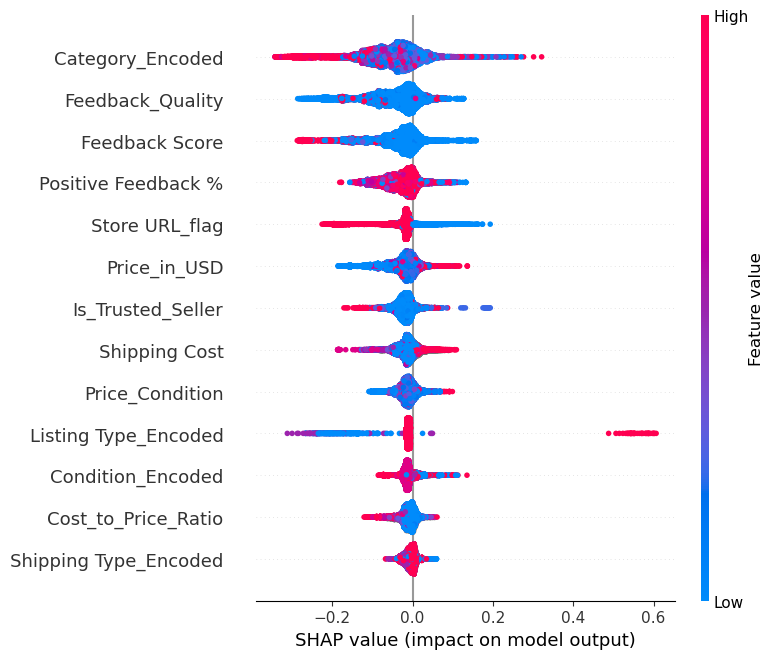

In [178]:
# 1. Global Feature Importance: Summary Plot (Dot Plot)
shap.summary_plot(shap_values.mean(axis=2), X_test_important)

# 1
  •	For Positive Feedback %:
	•	High values (red points) push the prediction positively (right of 0).
	•	Low values (blue points) tend to have a smaller or negative impact (left of 0).
# 2    
	•	Category_Encoded shows a wide spread, meaning its impact varies significantly across observations.
	•	Shipping Cost has a smaller spread, indicating more consistent contributions.
    
# 3
	•	Price_in_USD:
	•	High prices (red) slightly increase the prediction, while low prices (blue) have a weaker or neutral effect.
    
# 4
	•	Shipping Cost:
	•	High shipping costs (red) generally decrease the prediction (leftward SHAP values).
    
# 5
	•	Category_Encoded:
	•	Its high importance suggests the encoded category strongly influences the predictions.
	•	Red (high category values) and blue (low values) points show mixed impacts, implying that different categories affect the predictions in varying directions.

In [179]:
# 2. Partial Dependence Plots (PDP)

In [182]:
from sklearn.inspection import PartialDependenceDisplay

# Define the indices or names of the features to plot
multiple_features = list(range(X_test_important.shape[1]))  # Select all features or specify indices (e.g., [0, 1, 2])

# Generate the partial dependence plots
PartialDependenceDisplay.from_estimator(
    loaded_model,  # Replace with your trained model
    X_test_important,
    multiple_features,
    feature_names=X_test_important.columns,
    grid_resolution=20
)

# Add a title and adjust layout
plt.suptitle("Partial Dependence Plots for Selected Features", fontsize=14)
plt.tight_layout()
plt.show()

InvalidParameterError: The 'estimator' parameter of partial_dependence must be an object implementing 'fit' and 'predict', an object implementing 'fit' and 'predict_proba' or an object implementing 'fit' and 'decision_function'. Got <xgboost.core.Booster object at 0x3456200d0> instead.

In [184]:
pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [185]:
import graphviz
print(graphviz.__version__)  # Check if it's successfully imported

0.20.3


<Figure size 6000x3000 with 0 Axes>

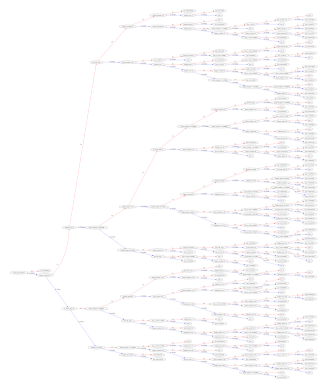

<Figure size 2000x1000 with 0 Axes>

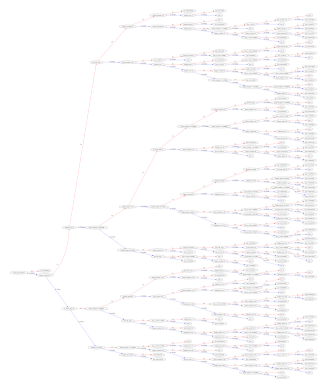

In [191]:
from xgboost import plot_tree

# Set the figure size for better clarity
plt.figure(figsize=(60, 30))  # Adjust the size as needed

# Plot the first tree in the model
plot_tree(loaded_model, num_trees=0, rankdir='LR')  # Horizontal layout
plt.show()

# Save the tree as a high-resolution image
plt.figure(figsize=(20, 10))  # Ensure the saved figure has the same size
plot_tree(loaded_model, num_trees=0, rankdir='LR')
plt.savefig('xgboost_tree_structure_high_res.png', dpi=1000)  # Increase DPI for higher resolution